In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import StandardScaler,PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

In [3]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [5]:
from collections import Counter
from sklearn.linear_model import LinearRegression
from numpy import inf

In [6]:
from sklearn.metrics import explained_variance_score, r2_score,mean_squared_error ,mean_absolute_error

In [7]:
from statsmodels.tsa import tsatools
import statsmodels.stats as stats
import statsmodels.stats.stattools as stools
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
import statsmodels.api as sm
from statsmodels.tsa import tsatools
from scipy import stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

In [8]:
%%time
df18=pd.read_excel("Transaction Data.xlsx",sheet_name='Transactions18')
df19=pd.read_excel("Transaction Data.xlsx",sheet_name='Transactions19')
fi=pd.read_excel("Firm Information.xlsx", sheet_name='Rep summary')

Wall time: 6.31 s


In [9]:
def fillna_values(df):    
    '''fill nan values with zero'''     
    if isinstance(df, type(pd.Series(dtype='float64'))):       
        return df.fillna(0)    
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)

Encoding

In [10]:
#selecting the n largest firm IDs for encoding
firmid=fi['Firm ID'].value_counts().nlargest(10).index.tolist()
fiid=fi.loc[:,'Firm ID'].copy()
for idf,fid in enumerate(fiid):
    if fid not in firmid:
        fiid[idf]='otherid'
fidc=fiid.copy()
fidc=fidc.to_numpy().reshape(-1,1)

In [11]:
markch=['Bank/Trust','Private Client Group','Asset Manager' ,
        'Discount','Networker','International Outlet','Low/Non Producer']

In [12]:
# for ma in markch:
#     fi['Channel'] = np.where((fi['Channel'] == ma),'other ch' , fi['Channel'])
# fi_mc=fi['Channel']
# fi_mc=fi_mc.to_numpy().reshape(-1,1)

In [13]:
#selecting the marketing sub-channel for encoding 
channels=['Global', 'DCIO', 'Other',
       'Affiliated']
for ch in channels:
    fi['Sub channel'] = np.where((fi['Sub channel'] == ch),'other sub' , fi['Sub channel'])
fi_o=fi['Sub channel']
fi_o=fi_o.to_numpy().reshape(-1,1)

In [14]:
ohe = OneHotEncoder(sparse=False)

In [15]:
#one-hot encoding of marketing sub-channel and largest Firm ids
fi_sub=ohe.fit_transform(fi_o)
fi_ch=pd.DataFrame(fi_sub,columns=['ch1','ch2','ch3','ch4','ch5'])
fi_firm=ohe.fit_transform(fidc)
fi_id=pd.DataFrame(fi_firm,columns=['fid1','fid2','fid3','fid4','fid5','fid6','fid7','fid8','fid9','fid10','fid11'])
# fi_mch=ohe.fit_transform(fi_mc)
# fi_mch=pd.DataFrame(fi_mch,columns=['ma1','ma2','ma3','ma4','ma5'])
#concatenation of encoded marketing sub-channel and largest Firm ids
enc=pd.concat((fi.loc[:,'Contact ID'],fi_ch,fi_id),axis=1)

In [16]:
df18.rename({'CONTACT_ID':'Contact ID'},axis=1,inplace=True)
df19.rename({'CONTACT_ID':'Contact ID'},axis=1,inplace=True)

In [17]:
df18=fillna_values(df18)
df19=fillna_values(df19)

In [18]:
fullfeat=pd.merge(df18, enc, on = 'Contact ID')

In [19]:
full_df=pd.merge(fullfeat, df19, on = 'Contact ID',suffixes=['_2018', '_2019'])

In [20]:
fullff=pd.merge(df18, fi, on = 'Contact ID')
fullfy=pd.merge(fullff, df19, on = 'Contact ID',suffixes=['_2018', '_2019'])

In [21]:
full_df.drop(['Contact ID', 'refresh_date_2019','refresh_date_2018',
                       'new_Fund_added_12M_2019'], axis=1, inplace=True)

In [22]:
full_df.iloc[:,-25:]

,aum_P_529,aum_P_ALT,aum_P_CEF,aum_P_ETF,aum_P_MF,aum_P_SMA,aum_P_UCITS,aum_P_UIT,ch1,ch2,...,fid3,fid4,fid5,fid6,fid7,fid8,fid9,fid10,fid11,sales_12M_2019
0,0.0,0.0,0.0,0.0,1.228660e+05,114614.07,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18633.105
1,0.0,0.0,0.0,0.0,1.962900e+04,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000
2,0.0,0.0,0.0,0.0,1.758700e+03,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000
3,0.0,0.0,0.0,0.0,5.794300e+04,0.00,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93212.000
4,0.0,0.0,0.0,0.0,-8.573590e+03,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,0.0,0.0,0.0,0.0,4.300891e+05,0.00,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,914411.060
10001,0.0,0.0,0.0,0.0,1.702046e+05,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,540906.000
10002,0.0,0.0,0.0,0.0,1.651608e+04,-232050.85,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,122282.970
10003,0.0,0.0,0.0,0.0,-1.245837e+06,0.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,207464.290


In [23]:
# full_df['Firm ID'].value_counts()

In [24]:
full_dec=full_df.copy()

In [25]:
chdec={}
chis=['ch1', 'ch2', 'ch3', 'ch4','ch5']
for cs in chis:
    for idc,rc in full_dec.iterrows():
        if rc[cs]==1.0:
            substr=fullfy.at[idc,'Sub channel']
            chdec[cs]=substr
chdec

{'ch1': 'IBD', 'ch2': 'NACS', 'ch3': 'RIA', 'ch4': 'USBT', 'ch5': 'other sub'}

In [26]:
fullfy.at[3,'Sub channel']

'IBD'

In [27]:
fdec={}
fis=['fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6', 'fid7', 'fid8',
       'fid9', 'fid10', 'fid11']
for fs in fis:
    for idf,rf in full_dec.iterrows():
        if rf[fs]==1.0:
            fistr=fullfy.at[idf,'Firm ID']
            fdec[fs]=fistr
fdec

{'fid1': '0001194',
 'fid2': '0002096',
 'fid3': '0022885',
 'fid4': '0033509',
 'fid5': '1471422',
 'fid6': '1567450',
 'fid7': '1688552',
 'fid8': '1948520',
 'fid9': '85201112683918276481',
 'fid10': '9000166',
 'fid11': '0001607'}

In [28]:
full_df['redemption_curr']=full_df['redemption_curr'].abs()
full_df['redemption_12M']=full_df['redemption_12M'].abs()

In [29]:
full_df[full_df<0]=0

In [30]:
y=full_df['sales_12M_2019']

In [31]:
full_df.drop(['sales_12M_2019'], axis=1, inplace=True)

In [32]:
features=full_df.copy()

In [33]:
features.columns

Index(['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
       'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
       'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
       'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
       'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
       'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
       'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
       'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
       'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
       'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
       'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT', 'ch1', 'ch2', 'ch3', 'ch4',
       'ch5', 'fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6', 'fid7', 'fid8',
       'fid9', 'fid10'

In [34]:
Xalt=features[['AUM',
 'sales_curr',
 'sales_12M_2018',
 'redemption_12M',
 'aum_AC_FIXED_INCOME_MUNI',
 'aum_P_MF']]

In [35]:
X=features.copy()
X.drop(['aum_AC_MONEY',
 'aum_AC_REAL_ESTATE',
 'aum_AC_TARGET',
 'aum_P_ALT',
 'aum_P_ETF',
 'aum_P_UCITS',
 'aum_P_UIT',
 'no_of_funds_sold_12M_1',
 'aum_AC_EQUITY',
 'aum_AC_FIXED_INCOME_MUNI'], axis=1, inplace=True)

In [36]:
X['redemption_12M'].value_counts()

0.00        4628
15.00         10
10000.00      10
30.00          9
3000.00        6
            ... 
22080.51       1
491.47         1
4999.50        1
30728.30       1
5140.29        1
Name: redemption_12M, Length: 5266, dtype: int64

# Applying ML Models

In [37]:
X_nn=X.copy()
y_nn=y.copy()
y_nn=y_nn.to_numpy()
X_nn.columns

Index(['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
       'no_of_Redemption_12M_10K', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
       'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr',
       'sales_12M_2018', 'redemption_curr', 'redemption_12M',
       'new_Fund_added_12M_2018', 'aum_AC_FIXED_INCOME_TAXABLE',
       'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY', 'aum_P_529',
       'aum_P_CEF', 'aum_P_MF', 'aum_P_SMA', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5',
       'fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6', 'fid7', 'fid8', 'fid9',
       'fid10', 'fid11'],
      dtype='object')

In [38]:
transfcols=['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
       'no_of_Redemption_12M_10K', 'no_of_funds_redeemed_12M_1',
       'no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K',
       'no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1',
       'no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K',
       'No_of_fund_curr', 'No_of_asset_curr', 'AUM', 'sales_curr',
       'sales_12M_2018', 'redemption_curr', 'redemption_12M',
       'new_Fund_added_12M_2018', 'aum_AC_FIXED_INCOME_TAXABLE',
       'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY', 'aum_P_529',
       'aum_P_CEF', 'aum_P_MF', 'aum_P_SMA']

In [39]:
# len(X_nn.columns)==len(transfcols)+16

In [40]:
Xlr=features['sales_curr']+features['sales_12M_2018'] 

In [41]:
X_tr, X_ts, y_tr, y_ts=train_test_split(Xlr,y_nn, test_size=0.25)

In [42]:
ss=StandardScaler()
ss2=StandardScaler()
Xtrs=ss.fit_transform(X_tr.to_numpy().reshape(-1,1))
Xtss=ss.transform(X_ts.to_numpy().reshape(-1,1))
ytrs=ss2.fit_transform(y_tr.reshape(-1,1))
ytss=ss2.transform(y_ts.reshape(-1,1))

In [43]:
lr=LinearRegression()

In [44]:
# lr.fit(Xtrs,ytrs)
# print("Validation score R2: \n",lr.score(Xtss, ytss))
# print("Mean Squared Error: \n",mean_squared_error(ytss, lr.predict(Xtss)))
# lr_results = cross_validate(lr, Xtss, ytss, cv=5)
# print("Cross Validate Scores: \n", lr_results['test_score'])

In [45]:
 sum([0.63774658 ,0.33567803, 0.40172681, 0.37997989, 0.05837563])/5

0.36270138799999996

In [46]:
X_train, X_test, y_train, y_test=train_test_split(X_nn,y_nn, test_size=0.25)

In [47]:
pt=PowerTransformer()
pt2=PowerTransformer()

In [48]:
y_train.shape

(7503,)

In [49]:
# X_nn[transfcols] = pt.fit_transform(X_nn[transfcols])
X_train2=pt.fit_transform(X_train)
X_test2=pt.transform(X_test)

y_train2=pt2.fit_transform(y_train.reshape(-1,1))
y_test2=pt2.transform(y_test.reshape(-1,1))

In [50]:
rfr_feat=RandomForestRegressor(n_estimators=100,max_depth=9)

In [51]:
rfr_feat.fit(X_train2,y_train2.ravel())
y_predp=rfr_feat.predict(X_test2)
# print("Validation score R2: \n",rfr_feat.score(X_test2, y_test2.ravel()))
# print("Mean Squared Error: \n",mean_squared_error(y_test2.ravel(), y_predp.ravel()))
# r_normal = cross_validate(rfr_feat, X_test2, y_test2.ravel(), cv=5)
# print("Cross Validate Scores: \n", r_normal['test_score'])

In [52]:
sum([0.52234568, 0.44775581, 0.55395322, 0.44560714, 0.54875647])/5

0.5036836640000001

In [53]:
rfr_feata=RandomForestRegressor(n_estimators=100,max_depth=9)

In [54]:
X_traina, X_testa, y_traina, y_testa=train_test_split(Xalt,y_nn, test_size=0.25)
pt3=PowerTransformer()
# pt4=PowerTransformer()
X_train2a=pt3.fit_transform(X_traina)
X_test2a=pt3.transform(X_testa)

y_train2a=pt2.fit_transform(y_traina.reshape(-1,1))
y_test2a=pt2.transform(y_testa.reshape(-1,1))
rfr_feata.fit(X_train2a,y_train2a.ravel())
y_predpa=rfr_feata.predict(X_test2a)
print("Validation score R2: \n",rfr_feata.score(X_test2a, y_test2a.ravel()))
print("Mean Squared Error: \n",mean_squared_error(y_test2a.ravel(), y_predpa.ravel()))
# ra_results = cross_validate(rfr_feata, X_test2a, y_test2a.ravel(), cv=5)
# print("Cross Validate Scores: \n", ra_results['test_score'])

Validation score R2: 
 0.5016393157599427
Mean Squared Error: 
 0.5031539105902414


In [1]:
from dtreeviz.trees import dtreeviz

ModuleNotFoundError: No module named 'dtreeviz'

https://mljar.com/blog/visualize-decision-tree/

In [ ]:
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(rfr_feata, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [55]:
sum([0.4630105 , 0.50086512, 0.51387623 ,0.48339253 ,0.48333277])/5

0.48889543

In [56]:
y_pred=pt2.inverse_transform(y_predp.reshape(-1,1))

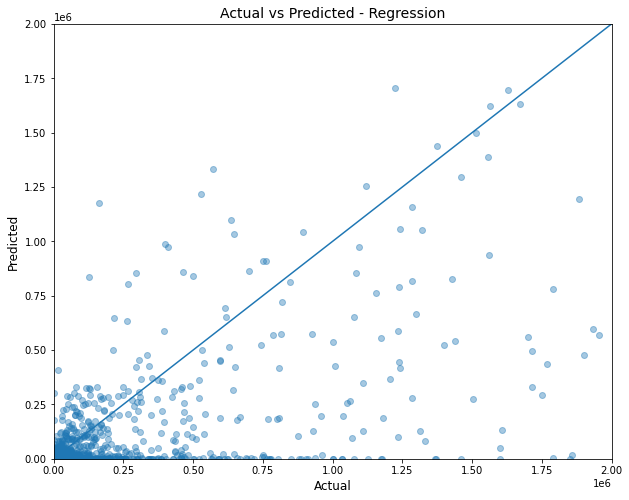

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.scatter(x=y_test, 
           y=y_pred, alpha=0.4)
ax.plot([0, 2000000], [0,2000000])
ax.set_xlim([0, 2000000])
ax.set_ylim([0, 2000000])
ax.set_title("Actual vs Predicted - Regression",fontsize=14)
ax.set_xlabel("Actual",fontsize=12)
ax.set_ylabel("Predicted",fontsize=12);

# Statsmodel I and Residuals

In [58]:
a=pt2.inverse_transform(y_test2.reshape(-1,1))
a=a.flatten()
b=pt2.inverse_transform(y_predp.reshape(-1,1))
b=b.flatten()

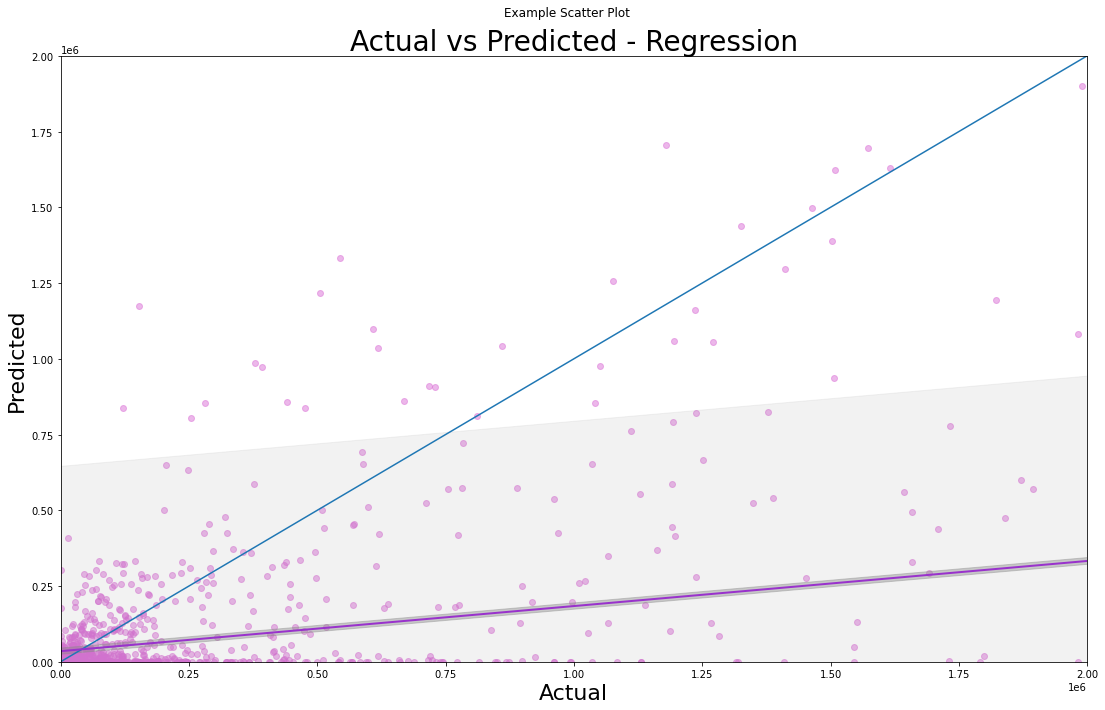

In [59]:
if a.shape ==b.shape:    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(x=a, 
               y=b, alpha=0.5, color='orchid')
    fig.suptitle('Example Scatter Plot')
    fig.tight_layout(pad=2);
    #------------
    a2 = sm.add_constant(a) # constant intercept term
    # Model: y ~ x + c
    model = sm.OLS(b,a2)
    fitted = model.fit()

    x_pred = np.linspace(a2.min(), a2.max(), 50)
    x_pred2 = sm.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    ax.plot([0, 2000000], [0,2000000])
    ax.set_xlim([0,2000000])
    ax.set_ylim([0, 2000000])

    ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)
    ax.set_title("Actual vs Predicted - Regression", fontsize=28)
    ax.set_xlabel("Actual", fontsize=22)
    ax.set_ylabel("Predicted", fontsize=22);
    #------------------------------------------------------------------------
#     confidence interval
    y_hat = fitted.predict(a2) 
    y_err = b - y_hat
    mean_x = a2.T[1].mean()
    n = len(a2)
    dof = n - fitted.df_model - 1
    t = stats.t.ppf(1-0.05, df=dof)#0.025 must be confidence intervall
    s_err = np.sum(np.power(y_err, 2))

    conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / 
        ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
    upper = y_pred + abs(conf)
    lower = y_pred - abs(conf)
    ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)
    #prediction intervall
    sdev, lower, upper = wls_prediction_std(fitted, exog=x_pred2, alpha=0.05)

    ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.1)
else:
    print('shapes dont match')

In [60]:
residuals = a - b

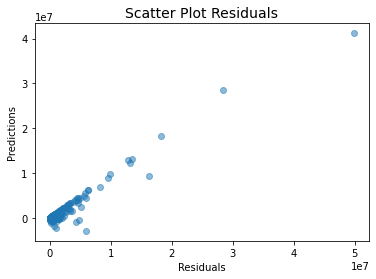

In [61]:
plt.scatter(x=a, y=residuals, alpha=0.5)
plt.title("Scatter Plot Residuals", fontsize=14)
plt.xlabel("Residuals")
plt.ylabel("Predictions");

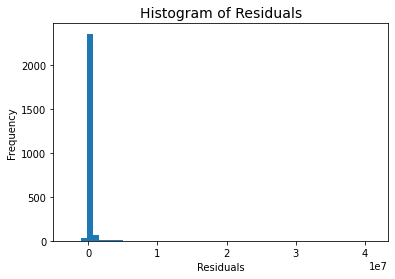

In [62]:
plt.hist(residuals, bins=50)
plt.title("Histogram of Residuals", fontsize=14)
plt.xlabel("Residuals")
plt.ylabel("Frequency");

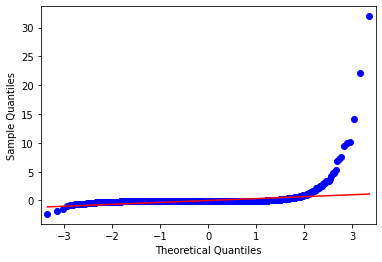

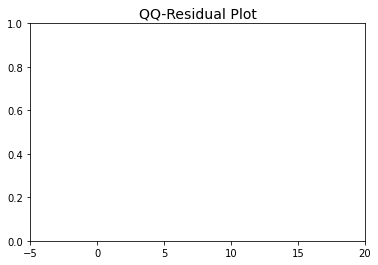

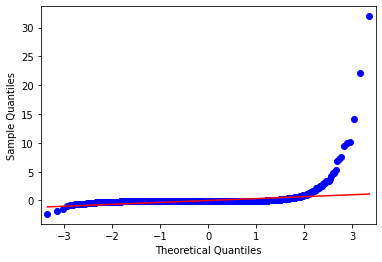

In [63]:
plt.title("QQ-Residual Plot", fontsize=14)
plt.xlim([-5, 20])
qqplot(residuals, fit=True, line='r')

# Leverage

In [64]:
# X_test3=X_test2.copy()
# # X_test3.replace([np.inf, -np.inf], np.nan).dropna(how="all",inplace=True)
# X_test3[~np.isnan(X_test3).any(axis=1)]

In [65]:
# x1=pt.inverse_transform(X_test3)
# x1 = np.where(np.isnan(x1), 0, x1)
# x1[x1 == -inf] = 0
# x1[x1 == inf] = 0
# y0=a
# y0=np.where(np.isnan(y0), 0, y0)
# y0[y0 == -inf] = 0
# y0[y0 == inf] = 0
# y1=b
# y1=np.where(np.isnan(y1), 0, y1)
# y1[y1 == -inf] = 0
# y1[y1 == inf] = 0

In [66]:
# np.isnan(x1).any()
# np.isfinite(x1).all()
# any(y0== float("inf"))

In [67]:
x1=pt3.inverse_transform(X_test2a)
y0=pt2.inverse_transform(y_test2a.reshape(-1,1))
y1=pt2.inverse_transform(y_predpa.reshape(-1,1))

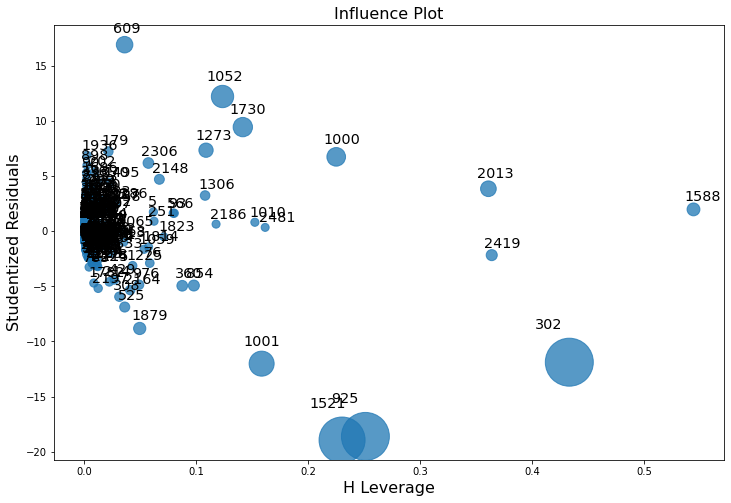

In [68]:
lm=sm.OLS(y1,sm.add_constant(x1)).fit()
# print('r2:'+str(lm.rsquared))
fig, ax=plt.subplots(figsize=(12,8))
fig=sm.graphics.influence_plot(lm, alpha=0.5,ax=ax,criterion='cooks')

In [69]:
levers=[229,1700,1361,1237,277,1463,1531]

In [70]:
def scatter_ys(a,b):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.scatter(x=a, 
               y=b, alpha=0.5, color='orchid')
    fig.suptitle('Example Scatter Plot')
    fig.tight_layout(pad=2);
    #------------
    a2 = sm.add_constant(a) # constant intercept term
    # Model: y ~ x + c
    model = sm.OLS(b,a2)
    fitted = model.fit()

    x_pred = np.linspace(a2.min(), a2.max(), 50)
    x_pred2 = sm.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    ax.plot([0, 200000], [0,200000])
    ax.set_xlim([0,200000])
    ax.set_ylim([0, 200000])
    
    for lev in levers:
        plt.scatter(a[lev],b[lev],color='green')
        ax.annotate(lev, (a[lev], b[lev]))

    ax.plot(x_pred, y_pred, '-', color='darkorchid', linewidth=2)
    ax.set_title("Actual vs Predicted - Regression", fontsize=28)
    ax.set_xlabel("Actual", fontsize=22)
    ax.set_ylabel("Predicted", fontsize=22);
    #------------------------------------------------------------------------
# #     confidence interval
#     y_hat = fitted.predict(a2) 
#     y_err = b - y_hat
#     mean_x = a2.T[1].mean()
#     n = len(a2)
#     dof = n - fitted.df_model - 1
#     t = stats.t.ppf(1-0.05, df=dof)#0.025 must be confidence intervall
#     s_err = np.sum(np.power(y_err, 2))

#     conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / 
#         ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
#     upper = y_pred + abs(conf)
#     lower = y_pred - abs(conf)
#     ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)
#     #prediction intervall
#     sdev, lower, upper = wls_prediction_std(fitted, exog=x_pred2, alpha=0.05)

#     ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.1)

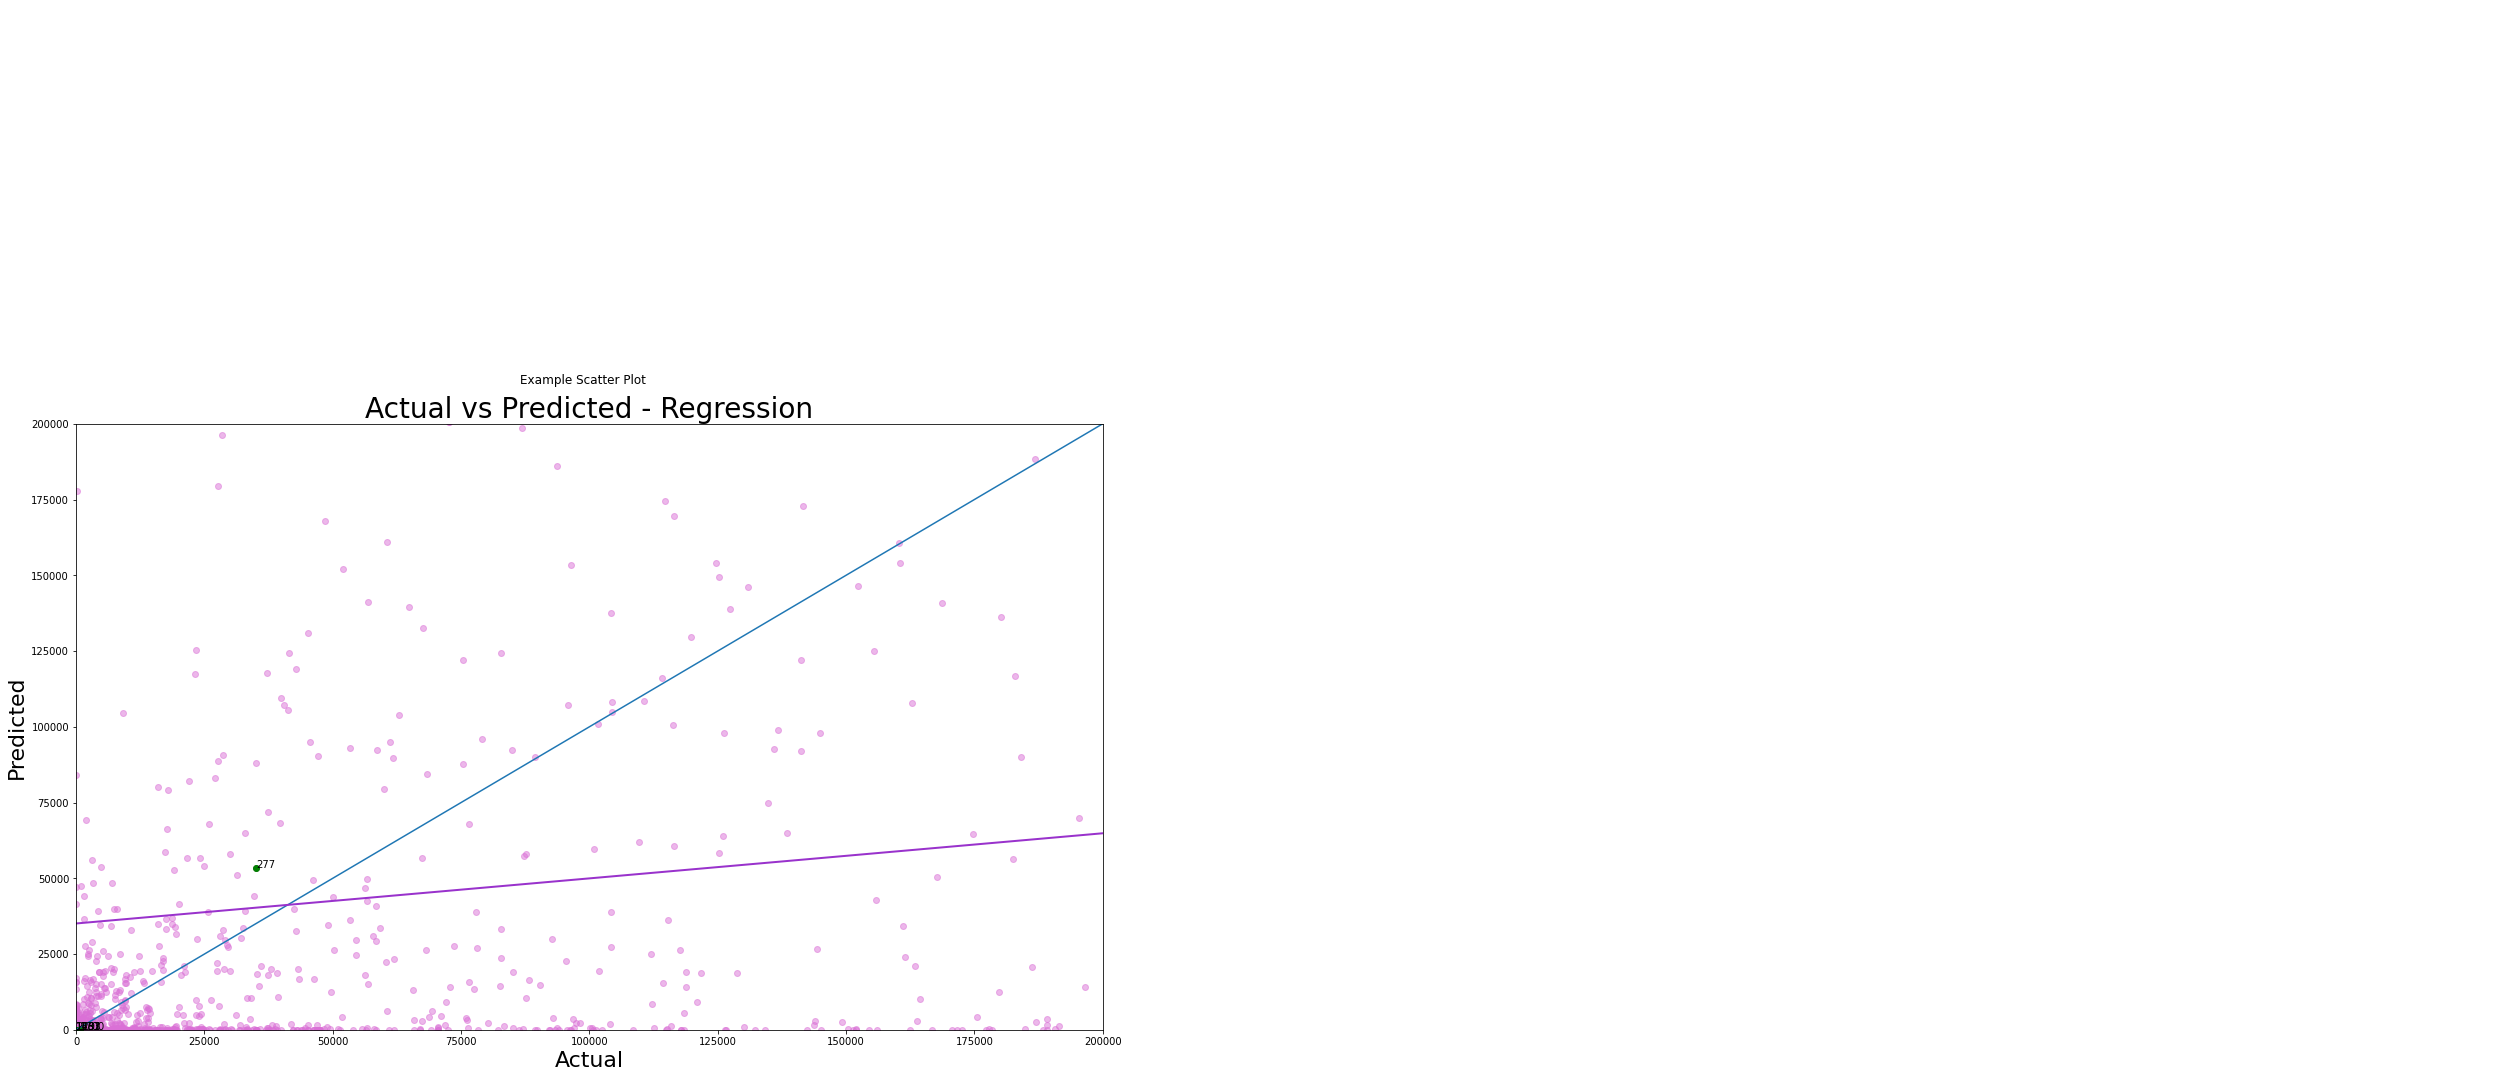

In [71]:
scatter_ys(a,b)

In [72]:
x1b=np.delete(x1, levers,0)
y0b=np.delete(y0,levers, 0)
y1b=np.delete(y1,levers, 0)

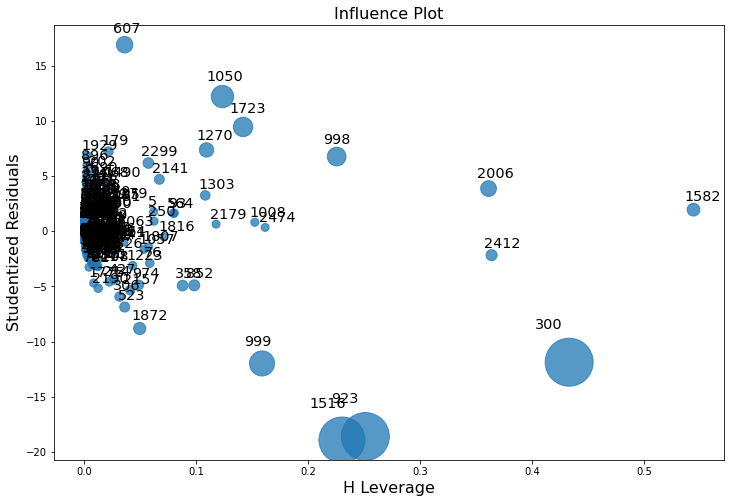

In [73]:
lm=sm.OLS(y1b,sm.add_constant(x1b)).fit()
fig, ax=plt.subplots(figsize=(12,8))
fig=sm.graphics.influence_plot(lm, alpha=0.5,ax=ax,criterion='cooks')

In [74]:
levers=[1605,1117,800,1885]

In [75]:
x1c=np.delete(x1b, levers,0)
y0c=np.delete(y0b,levers, 0)
y1c=np.delete(y1b,levers, 0)

In [76]:
rfrl=RandomForestRegressor(n_estimators=100,max_depth=9)

In [77]:
Xtr_c, Xts_c, ytr_c, yts_c=train_test_split(x1c,y0c, test_size=0.25)
pt4=PowerTransformer()
pt5=PowerTransformer()
Xtr_cp=pt4.fit_transform(Xtr_c)
Xts_cp=pt4.transform(Xts_c)

ytr_cp=pt5.fit_transform(ytr_c.reshape(-1,1))
yts_cp=pt5.transform(yts_c.reshape(-1,1))


rfrl.fit(Xtr_cp,ytr_cp.ravel())
# y_predpa=rfr_feata.predict(X_test2a)
print("Validation score R2: \n",rfrl.score(Xts_cp, yts_cp.ravel()))
print("Mean Squared Error: \n",mean_squared_error(yts_cp.ravel(), rfrl.predict(Xts_cp)))
rl_results = cross_validate(rfrl, Xts_cp, yts_cp.ravel(), cv=5)
print("Cross Validate Scores: \n", rl_results['test_score'])

Validation score R2: 
 0.4951047118010198
Mean Squared Error: 
 0.5159920804861455
Cross Validate Scores: 
 [0.42050829 0.40196589 0.48726222 0.48092235 0.41142034]


In [78]:
sum([0.43260979, 0.3713637,  0.47304039, 0.44734046, 0.38552151])/5

0.42197516999999996

# EDA

In [79]:
test_list=X_test.index.values.tolist()

In [80]:
Xtsli=X.iloc[test_list]
Xtsli['sales_2018']=Xtsli['sales_12M_2018']+Xtsli['sales_curr']
Xtsli['redemption']=Xtsli['redemption_curr']+Xtsli['redemption_12M']

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
Xts_sel=Xtsli[['AUM','ch1', 'ch2', 'ch3','ch4','ch5','sales_2018','redemption']]

In [82]:
chis=['ch1', 'ch2', 'ch3', 'ch4','ch5']
# build dictionary for automatic assignment of column index to marketing channel!-done
for cs in chis:
    for idy,xs in Xts_sel.iterrows():
        if xs[cs]==1.0:
            sbstr=chdec.get(cs)
            Xts_sel.loc[idy,'Sub channel']=sbstr         

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [83]:
yts_i=pd.DataFrame(a,index=X_test.index)
yts_ip=pd.DataFrame(b,index=X_test.index)

In [84]:
full_te=pd.concat((Xts_sel,yts_i), axis=1)
full_te.rename({0:'sales 2019'},axis=1,inplace=True)
full_test=pd.concat((full_te,yts_ip), axis=1)
full_test.rename({0:'sales 2019 pred'},axis=1,inplace=True)
full_test.head(10)

,AUM,ch1,ch2,ch3,ch4,ch5,sales_2018,redemption,Sub channel,sales 2019,sales 2019 pred
3053,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,2.308010
4259,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,6.135134
8388,719361.772537,0.0,1.0,0.0,0.0,0.0,19995.83355,57509.61513,NACS,1554.224333,16231.354036
4697,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,2.308010
609,0.000000,1.0,0.0,0.0,0.0,0.0,4616.72000,243.10000,IBD,-0.015342,95.378681
3243,43284.970000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,1.261921
2480,844712.300000,0.0,1.0,0.0,0.0,0.0,0.00000,90681.63000,NACS,55661.267641,104.688629
9262,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,6.591496
1298,110363.300000,0.0,1.0,0.0,0.0,0.0,0.00000,0.00000,NACS,-0.015342,1.287150
9340,0.000000,1.0,0.0,0.0,0.0,0.0,0.00000,0.00000,IBD,-0.015342,2.308010


In [92]:
full_test.to_csv('regr_testnov23.csv')

In [93]:
Xts_fs=Xtsli[['AUM','fid1','fid2','fid3','fid4','fid5','fid6','fid7','fid8','fid9','fid10','fid11','sales_2018','redemption']]

In [94]:
fis=['fid1', 'fid2', 'fid3', 'fid4', 'fid5', 'fid6', 'fid7', 'fid8',
       'fid9', 'fid10', 'fid11']
for fs in fis:
    for idf,xf in Xts_fs.iterrows():
        if xf[fs]==1.0:
            sbstr=fdec.get(fs)
            Xts_fs.loc[idf,'Firm ID']=sbstr         

In [95]:
full_tef=pd.concat((Xts_fs,yts_i), axis=1)
full_tef.rename({0:'sales 2019'},axis=1,inplace=True)
full_tf=pd.concat((full_tef,yts_ip), axis=1)
full_tf.rename({0:'sales 2019 pred'},axis=1,inplace=True)
full_tf.head(10)

,AUM,fid1,fid2,fid3,fid4,fid5,fid6,fid7,fid8,fid9,fid10,fid11,sales_2018,redemption,Firm ID,sales 2019,sales 2019 pred
3053,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0001607,-0.015342,2.308010
4259,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0002096,-0.015342,6.135134
8388,719361.772537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,19995.83355,57509.61513,1948520,1554.224333,16231.354036
4697,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0001607,-0.015342,2.308010
609,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4616.72000,243.10000,1471422,-0.015342,95.378681
3243,43284.970000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0022885,-0.015342,1.261921
2480,844712.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00000,90681.63000,1948520,55661.267641,104.688629
9262,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0001194,-0.015342,6.591496
1298,110363.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.00000,9000166,-0.015342,1.287150
9340,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.00000,0001607,-0.015342,2.308010


In [96]:
full_tf.to_csv('regr_tsfirmsnov23.csv')

In [97]:
full_tf['Firm ID'].value_counts()

0001607                 1116
1471422                  238
1948520                  222
1567450                  206
0022885                  203
9000166                  123
0001194                  122
1688552                   93
0002096                   64
0033509                   64
85201112683918276481      51
Name: Firm ID, dtype: int64